# Subclustering B cell types

In this notebook, we sub-cluster B cell types after filtering out Immunoglobulin-related genes. Because these genes are highly and discretely expressed by B cells, their expression can mask other functional features of B cell populations in approaches like PCA, which is used as input for our neighborhood finding, clustering, and 2D embeddings.

After reclustering, we also subset and iteratively cluster non-effector Memory B cells to identify specific subsets of cells within this population. These deeper looks at B cell populations were used to guide expert annotation of B cells at a high resolution.

## Load Packages

In [1]:
from datetime import date
import hisepy
import scanpy as sc
import pandas as pd
import numpy as np
import os
import scanpy.external as sce
import matplotlib.pyplot as plt
import math

## Helper function

This helper function allows us to select clusters based on a gene detection cutoff.

In [2]:
def select_clusters_by_gene_frac(adata, gene, cutoff, clusters = 'leiden'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = gene,
        return_fig = True
    ).dot_size_df

    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

## Read B cell dataset from HISE

In [3]:
h5ad_uuid = '25032725-d25a-402e-9adf-f34353443507'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [4]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [5]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [6]:
adata = sc.read_h5ad(h5ad_file)

In [7]:
adata

AnnData object with n_obs × n_vars = 177994 × 1274
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_reso

In [8]:
adata = adata.raw.to_adata()

## Identify and remove IGH, IGK, and IGL genes

Genes with Ig heavy chain (IGH) and kappa and lambda light chain (IGK and IGL, respectively) prefixes are identified within our dataset here:

In [9]:
igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

We then reset our B cell data, select highly variable genes, and then filter out these features for our analysis:

In [10]:
adata.raw = adata

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]
filtered_genes = [gene for gene in adata.var_names if gene not in exl_genes]
adata = adata[:, filtered_genes]

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [12]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sce.pp.harmony_integrate(
    adata, 
    'cohort.cohortGuid',
    max_iter_harmony = 30
)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-02-26 20:07:03,002 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-26 20:08:02,467 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-26 20:08:03,431 - harmonypy - INFO - Iteration 1 of 30
2024-02-26 20:09:52,205 - harmonypy - INFO - Iteration 2 of 30
2024-02-26 20:11:41,169 - harmonypy - INFO - Converged after 2 iterations


In [13]:
sc.pp.neighbors(
    adata, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)
sc.tl.umap(adata, min_dist=0.05)

In [14]:
sc.tl.leiden(
    adata, 
    resolution = 2, 
    key_added = "ms_leiden_2"
)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [15]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [16]:
cell_class = 'b-cells-no-ig'
no_ig_h5ad = 'output/ref_pbmc_{c}_subset_{d}.h5ad'.format(c = cell_class, d = date.today())
adata.write_h5ad(no_ig_h5ad)

## Save UMAP coordinates and labels

In [17]:
umap_mat = adata.obsm['X_umap']

In [18]:
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

In [19]:
obs = adata.obs
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [20]:
no_ig_csv = 'output/ref_{c}_clustered_umap_meta_{d}.csv'.format(c = cell_class, d = date.today())

In [21]:
obs.to_csv(no_ig_csv)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/

In [22]:
no_ig_parquet = 'output/ref_{c}_clustered_umap_meta_{d}.parquet'.format(c = cell_class, d = date.today())

In [23]:
obs = obs.to_parquet(no_ig_parquet)

## Plots to inspect B cell clusters

In [24]:
adata = adata.raw.to_adata()

In [25]:
adata

AnnData object with n_obs × n_vars = 177994 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_res

In [26]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### UMAP: New Leiden clusters

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


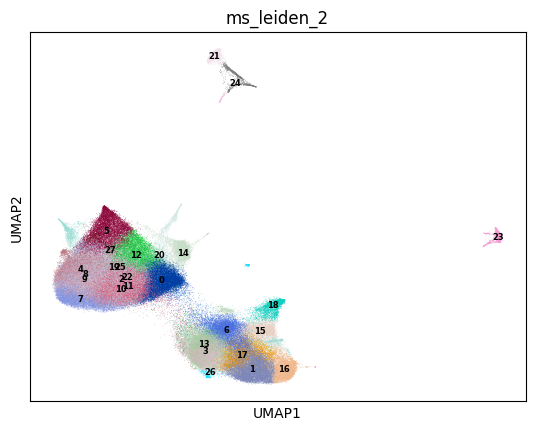

In [27]:
sc.pl.umap(adata, color = 'ms_leiden_2', legend_loc='on data', legend_fontsize=6)

### UMAP: Doublet score

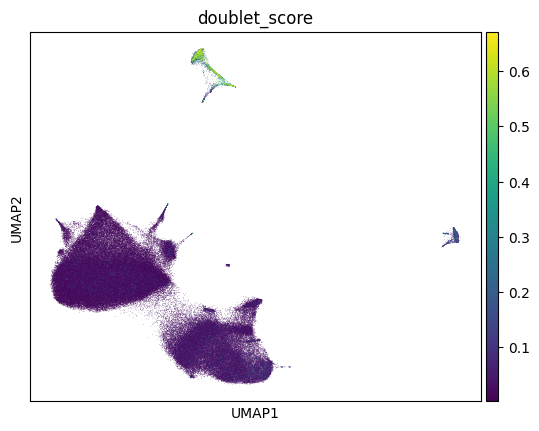

In [28]:
sc.pl.umap(adata, color=['doublet_score'])

Cells in Clusters 19 and 22 are likely doublets that have snuck through our scrublet processing.

### Dot Plot: Marker genes

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


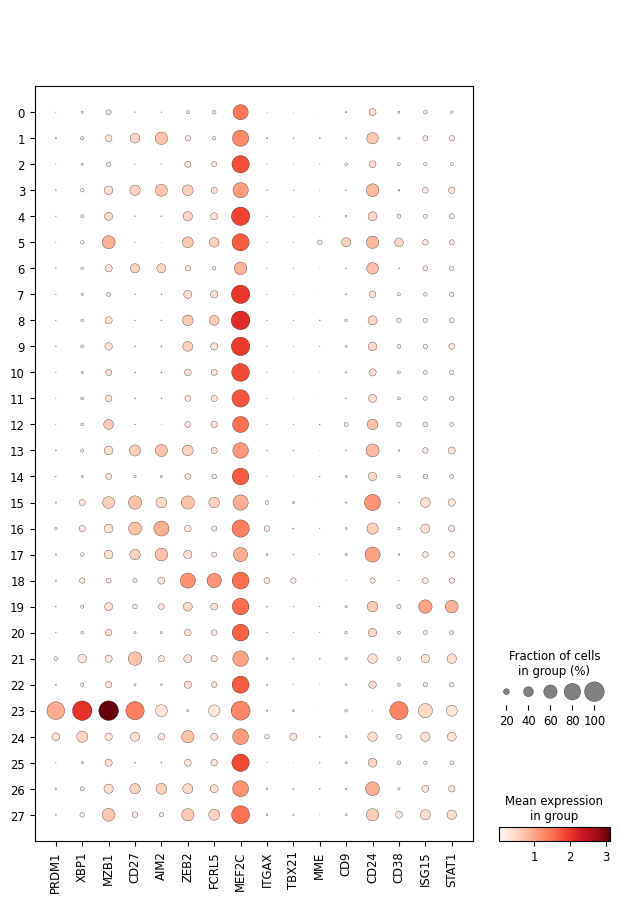

In [29]:
gene_symbols = [
    'PRDM1', 'XBP1', 'MZB1', 
    'CD27', 'AIM2', 'ZEB2', 
    'FCRL5', 'MEF2C', 'ITGAX', 
    'TBX21', 'MME', 'CD9', 
    'CD24', 'CD38', 'ISG15', 
    'STAT1'
]
sc.pl.dotplot(adata, gene_symbols, groupby='ms_leiden_2')

In [30]:
adata.shape

(177994, 33538)

### IGH in plasma cells of BR1 vs BR2

Immunoglobulin heavy chain expression may vary between our two cohorts. 

We'll select plasma cells to get a preview of heavy chain usage in BR1 (young adult) and BR2 (older adult) plasma cells

In [31]:
# Plasma Cells
prdm1_pos_cl = select_clusters_by_gene_frac(adata, gene = 'PRDM1', cutoff = 0.5, clusters = 'ms_leiden_2')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


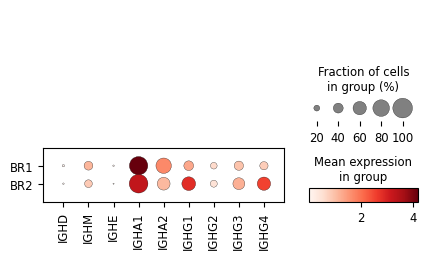

In [32]:
plasma_cluster = prdm1_pos_cl
plasma = adata[adata.obs['ms_leiden_2'].isin(plasma_cluster)]
plasma = plasma[plasma.obs['cohort.cohortGuid'].isin(['BR1', 'BR2'])]
igh_genes = ['IGHD', 'IGHM', 'IGHE', 'IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4']
sc.pl.dotplot(plasma, igh_genes, groupby='cohort.cohortGuid')

### UMAP: Marker gene sets

To assist with annotation, we'll plot sets of marker genes associated with B cell subpopulations.

In [33]:
markers = {
    'plasma': ['PRDM1', 'XBP1', 'MZB1'],
    'effector': ['CD27', 'ITGAX', 'TBX21', 'ZEB2', 'FCRL5', 'MEF2C'],
    'transitional': ['MME', 'CD9', 'CD24', 'CD38'],
    'naive': ['IGHD', 'CD27', 'CD44', 'CD9', 'STAT1', 'IFI44L'],
    'memory': ['CD27', 'AIM2', 'IGHD'],
    't2': ['FCER2', 'IL4R', 'IGHE', 'MEF2C'],
    'cd95': ['CD27', 'AIM2', 'FAS'],
    'hbb': ['HBB', 'HBA2', 'HBA1'],
    'isg_naive': ['IFI44L', 'STAT1'],
}

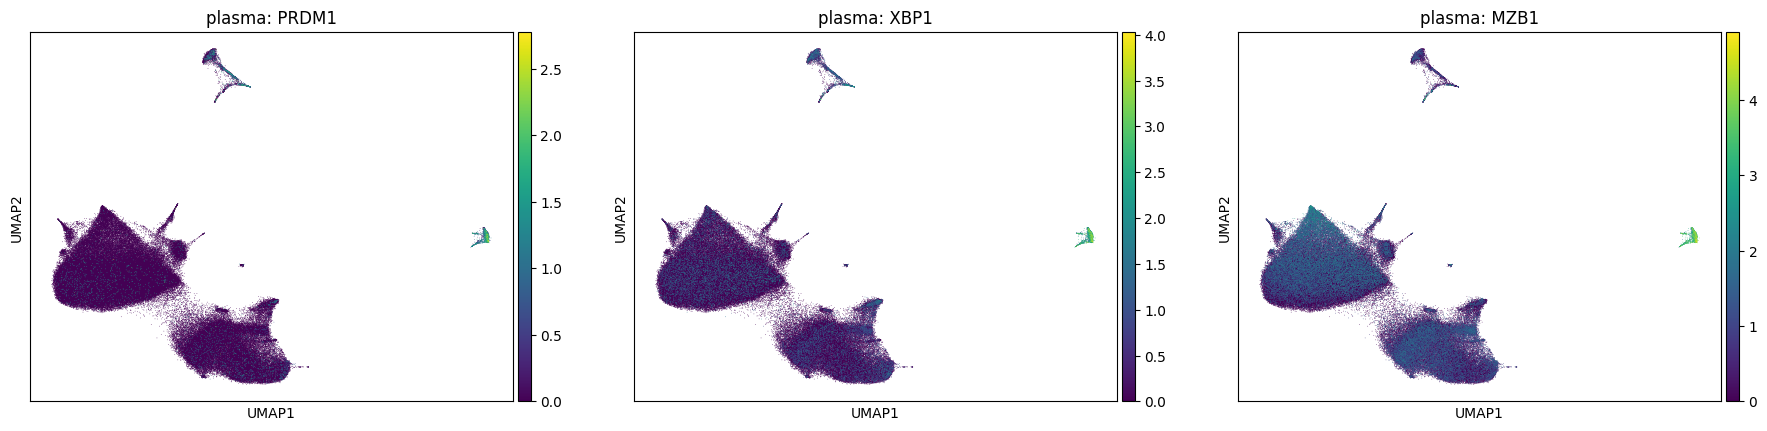

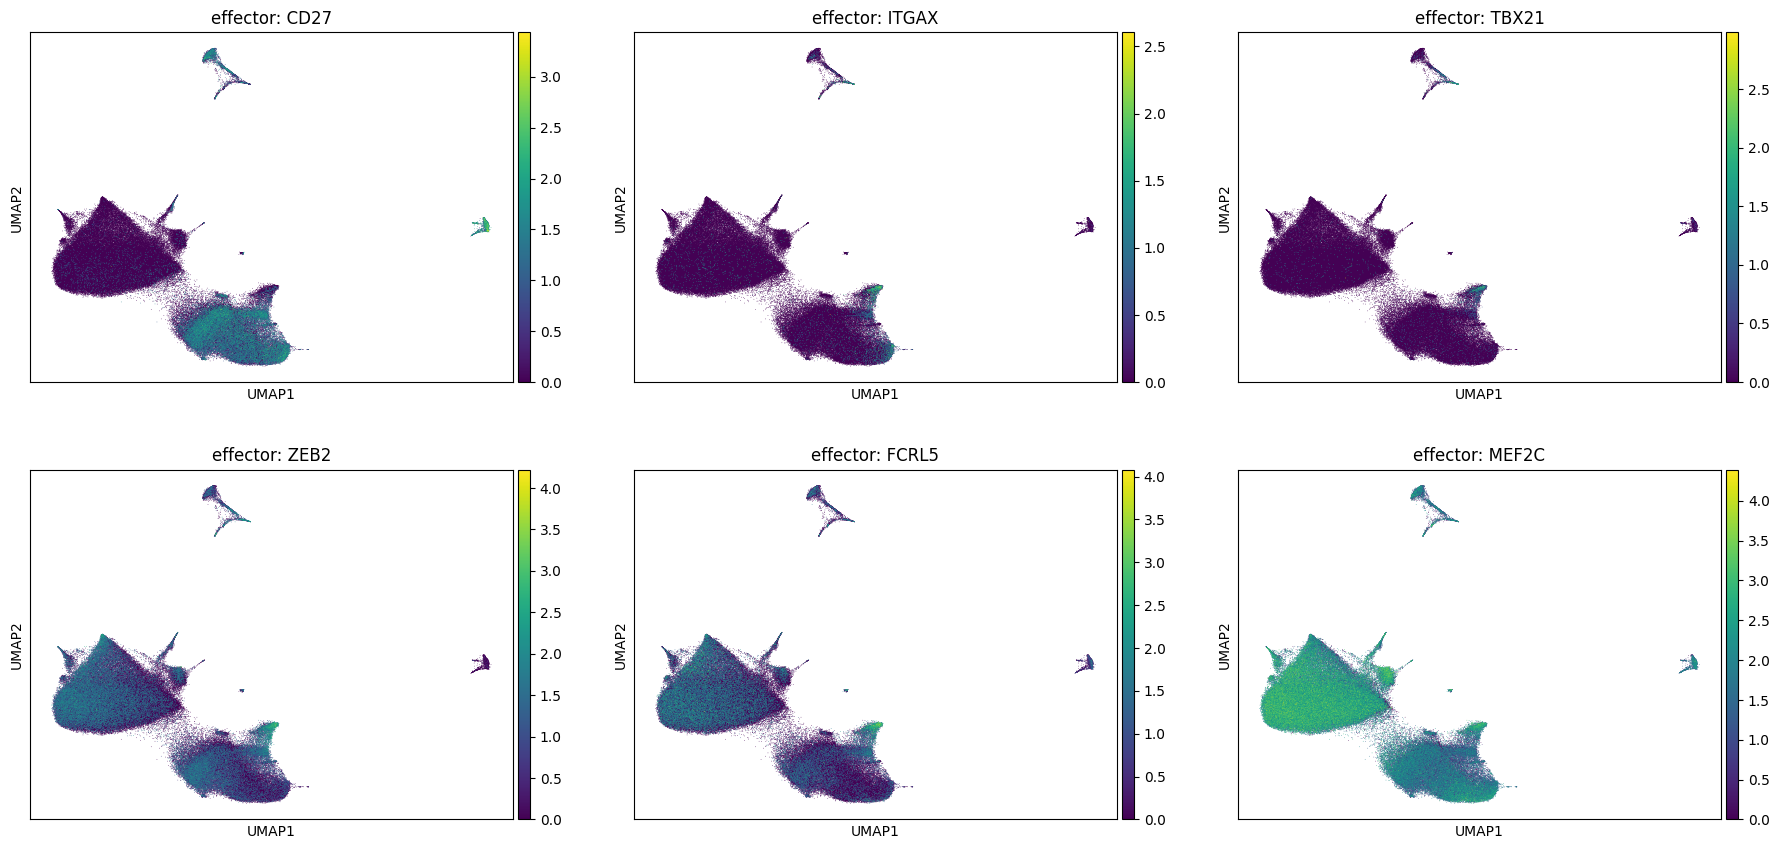

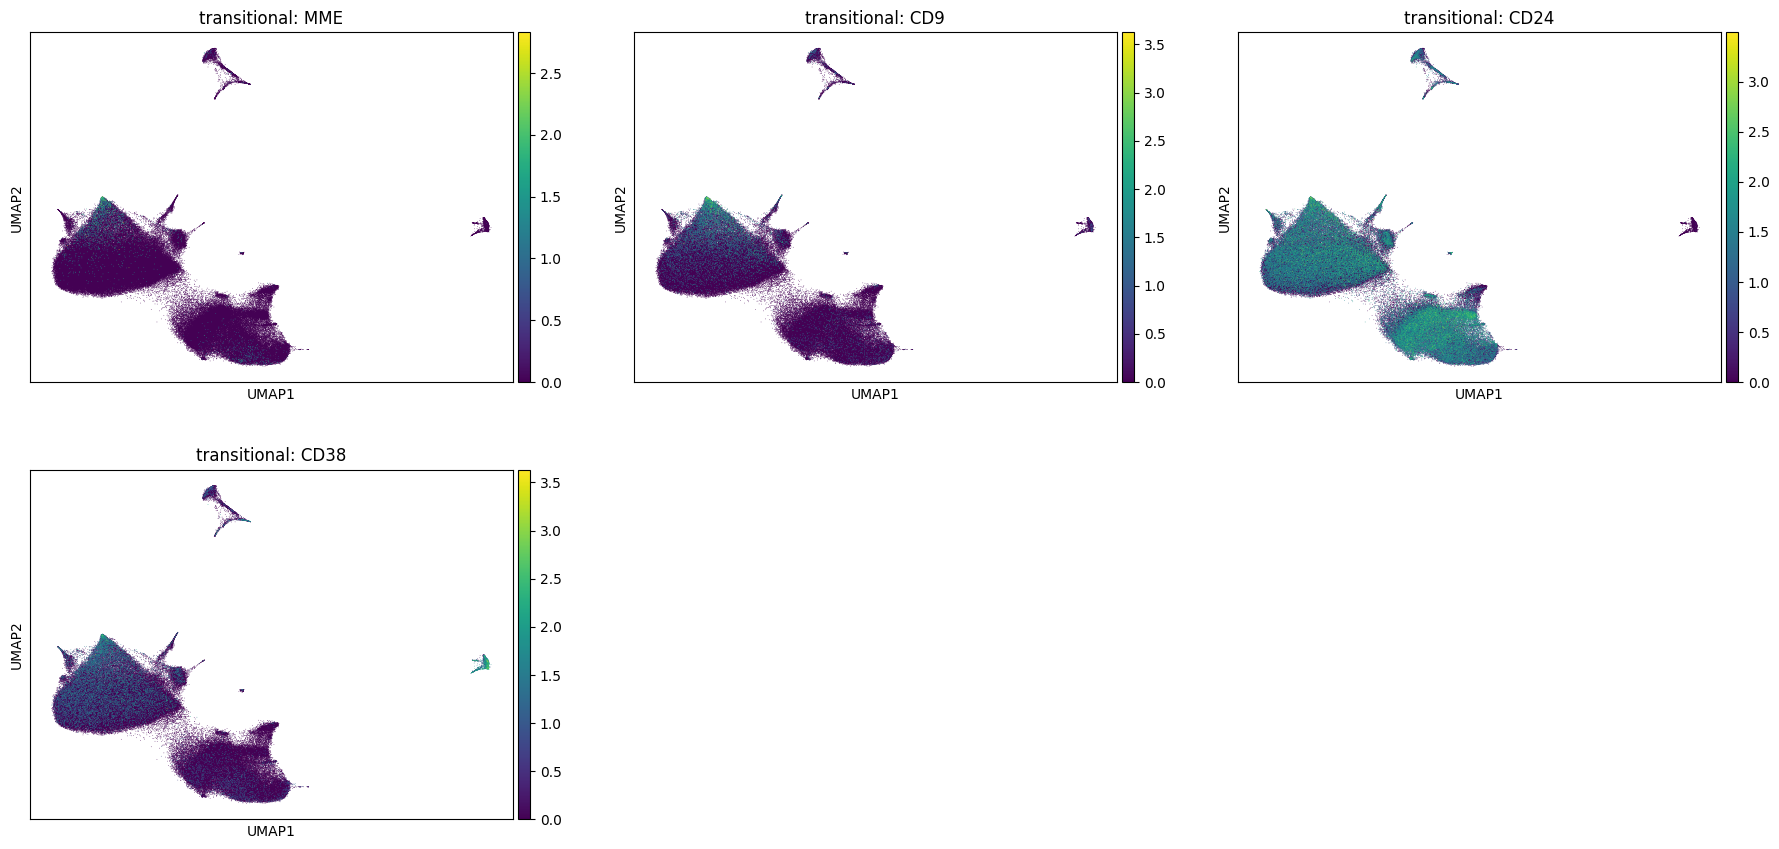

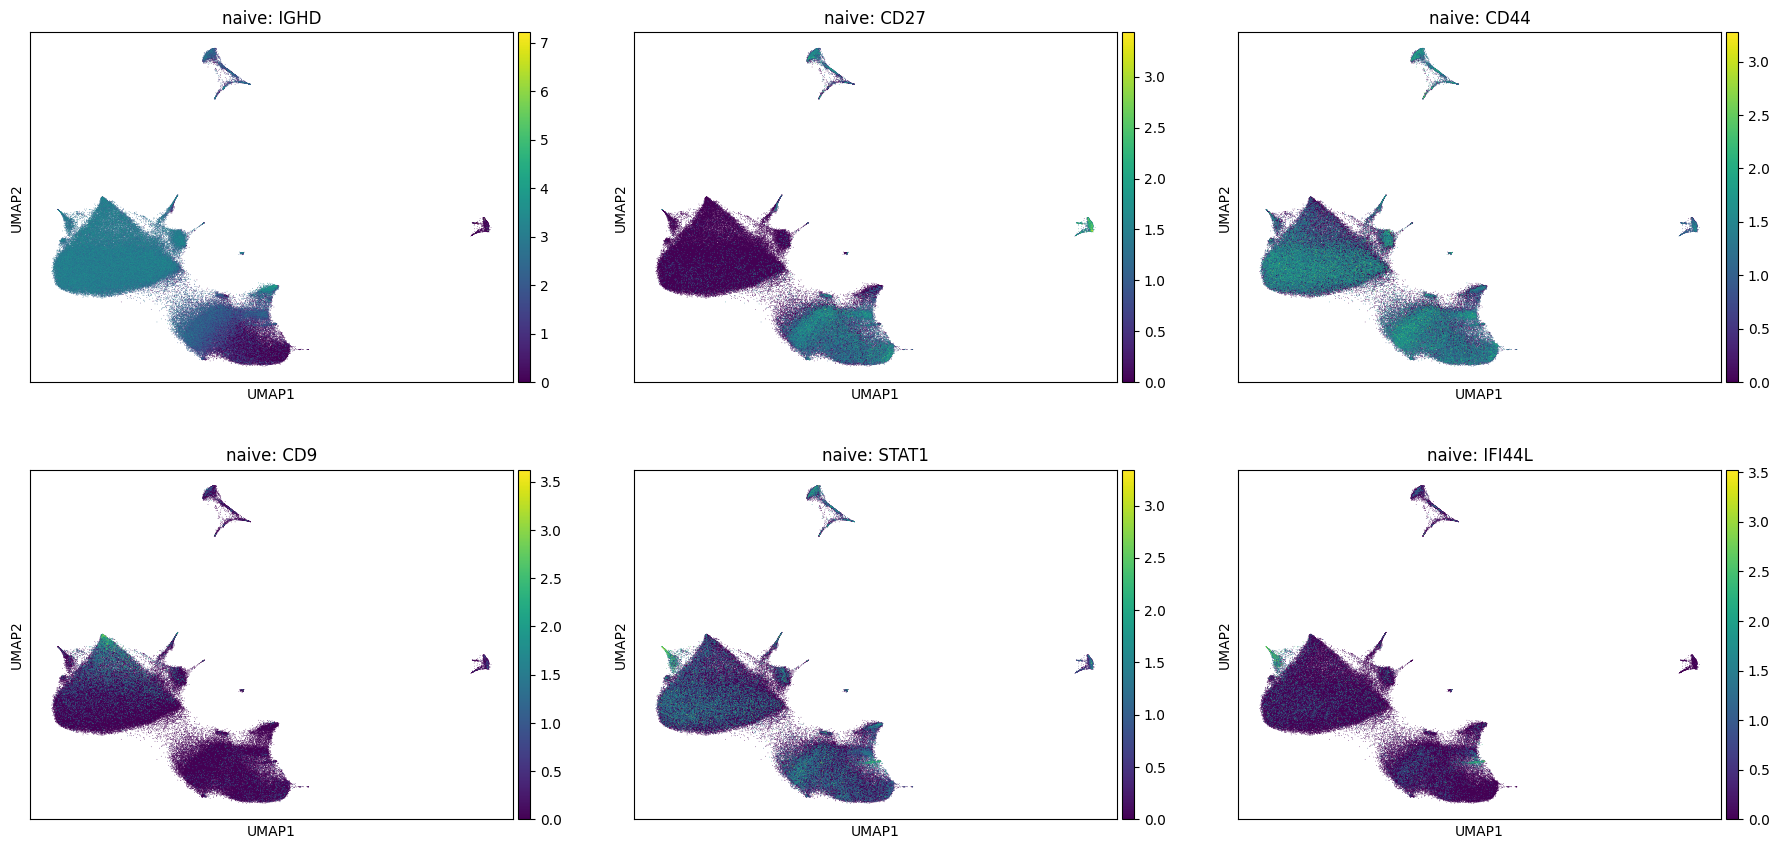

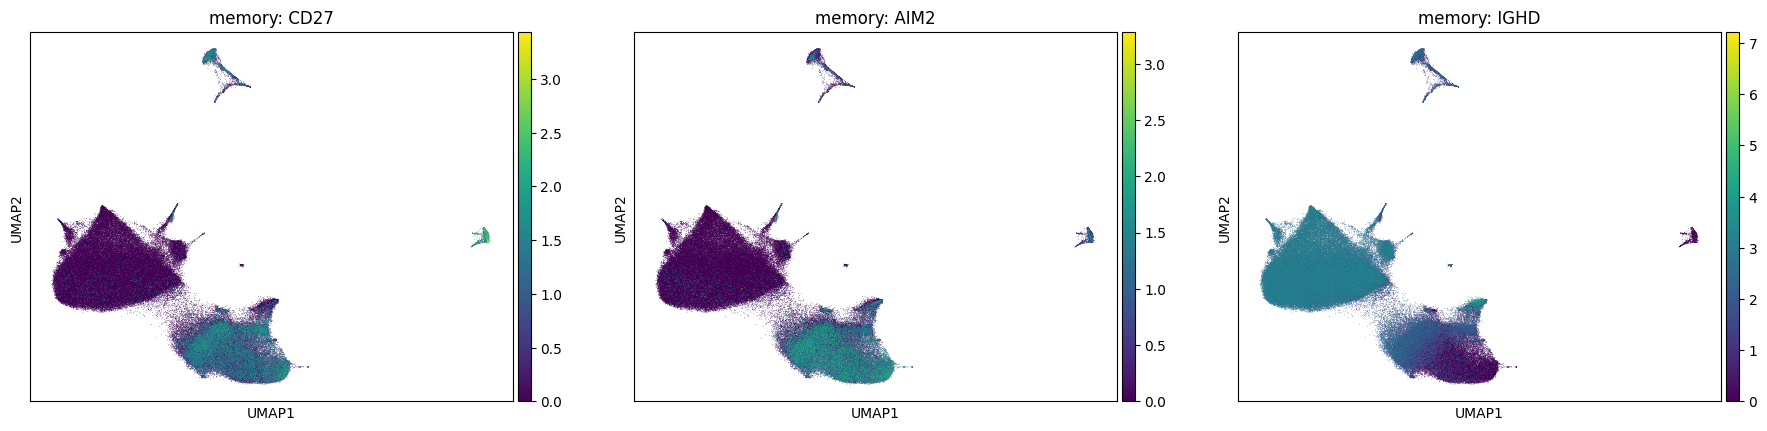

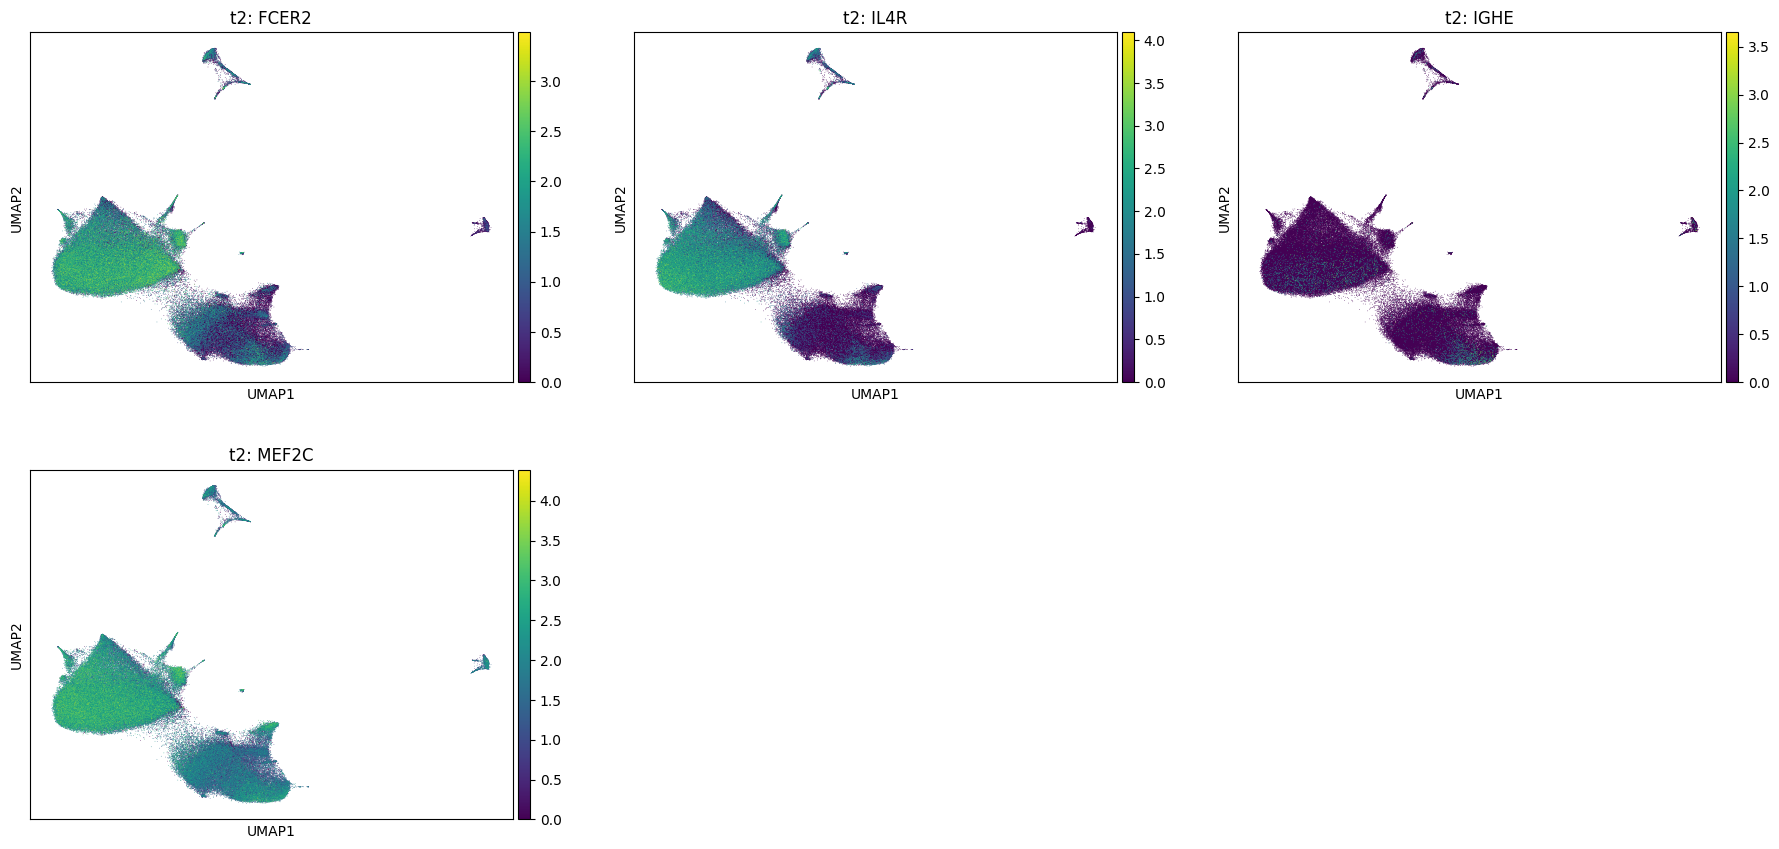

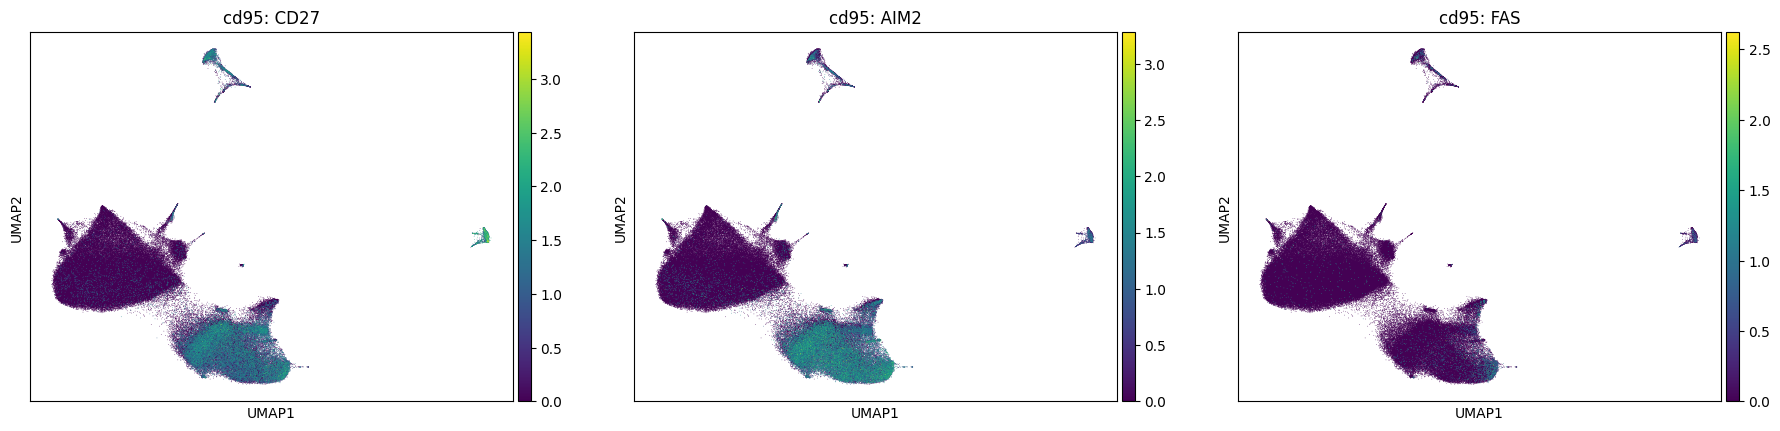

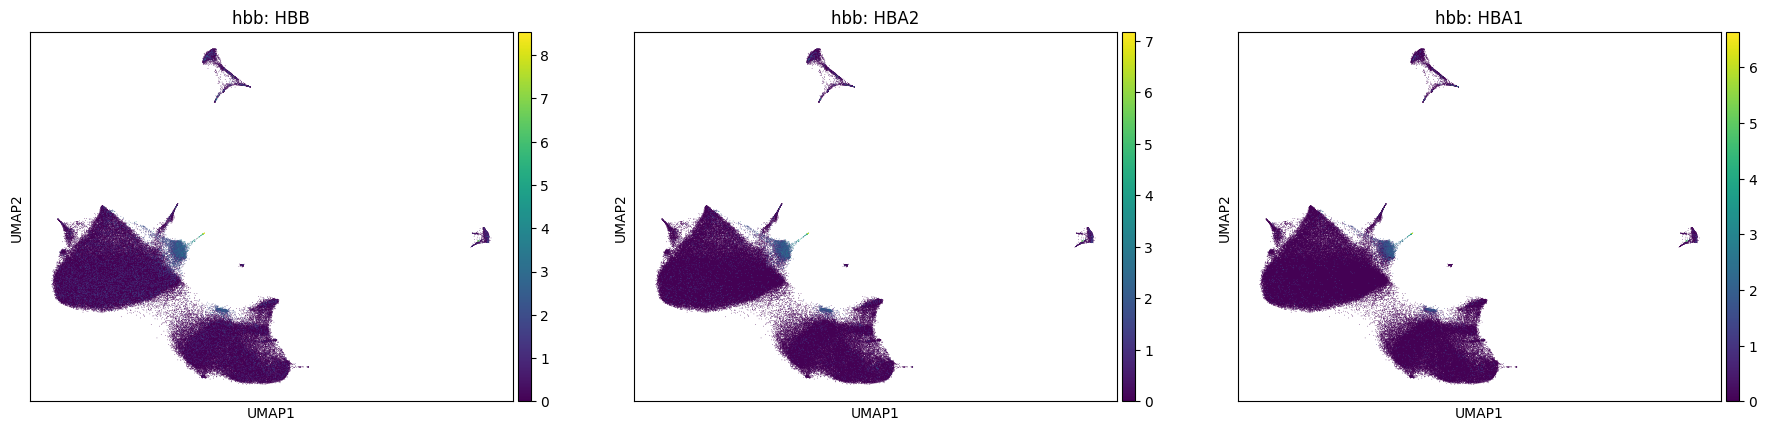

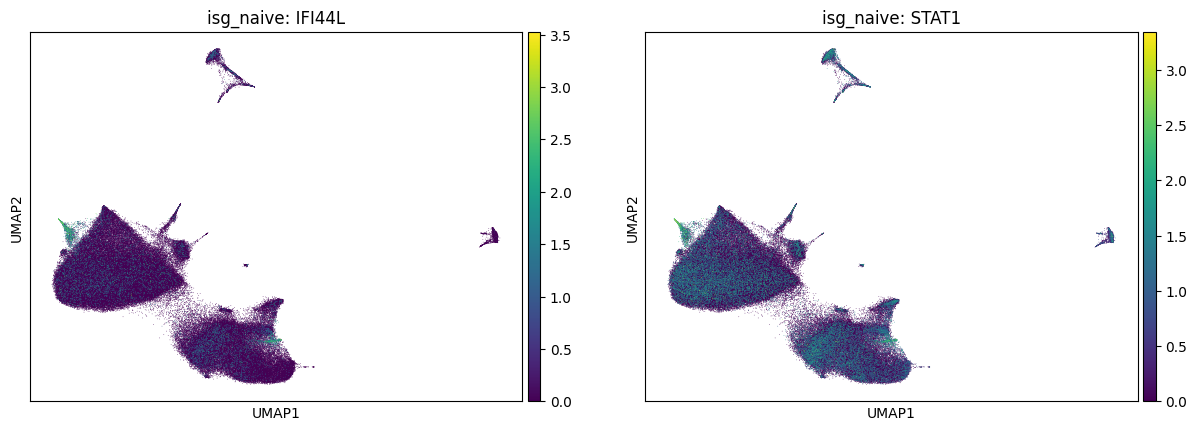

In [34]:
for panel,genes in markers.items():
    titles = [panel + ': ' + g for g in genes]
    sc.pl.umap(
        adata, 
        color = genes, 
        size = 1, 
        ncols = 3, 
        frameon = True,
        title = titles
    )

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_resolution_2'}, xlabel='UMAP1', ylabel='UMAP2'>

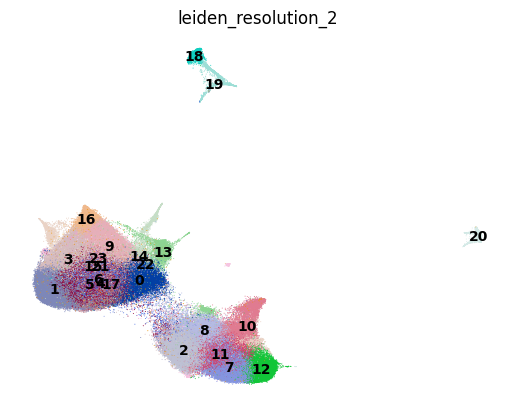

In [35]:
sc.pl.umap(
    adata, 
    color = ['leiden_resolution_2'], 
    legend_loc = 'on data',
    size = 2,
    show = False,
    ncols = 1,
    frameon = False)

## Subcluster Non-Effector Memory B cells

To get additional resolution on Memory B cell types, we'll select AIM2-positive clusters, and remove effector memory cells (ZEB2-positive clusters), and plasma cells (PRDM1-positive clusters), then perform another iterative round of clustering to get additional resolution.

In [36]:
# Most memory clusters
aim2_pos_cl = select_clusters_by_gene_frac(adata, gene = 'AIM2', cutoff = 0.3, clusters = 'ms_leiden_2')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


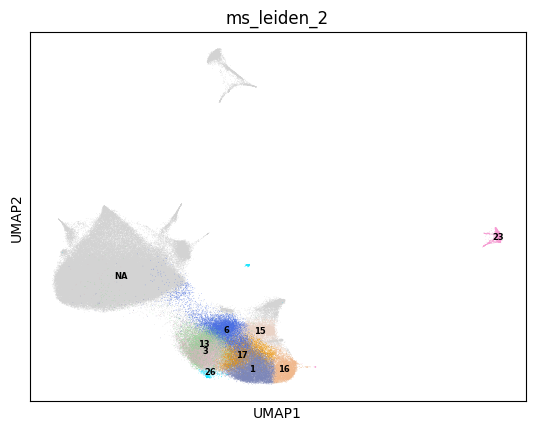

In [37]:
sc.pl.umap(adata, color = 'ms_leiden_2', groups = aim2_pos_cl, 
           legend_loc='on data', legend_fontsize=6)

In [38]:
# Effectors
zeb2_pos_cl = select_clusters_by_gene_frac(adata, gene = 'ZEB2', cutoff = 0.5, clusters = 'ms_leiden_2')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


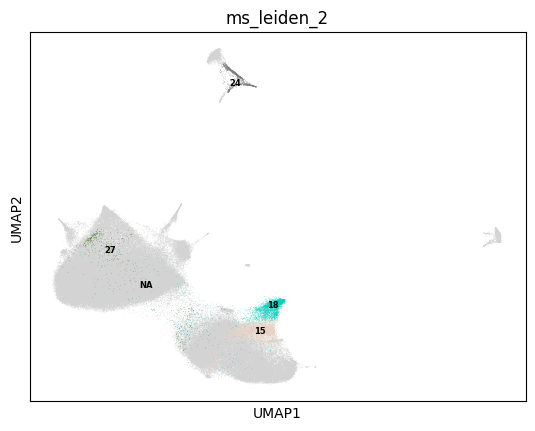

In [39]:
sc.pl.umap(adata, color = 'ms_leiden_2', groups = zeb2_pos_cl, 
           legend_loc='on data', legend_fontsize=6)

In [40]:
# Plasma Cells
prdm1_pos_cl = select_clusters_by_gene_frac(adata, gene = 'PRDM1', cutoff = 0.5, clusters = 'ms_leiden_2')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


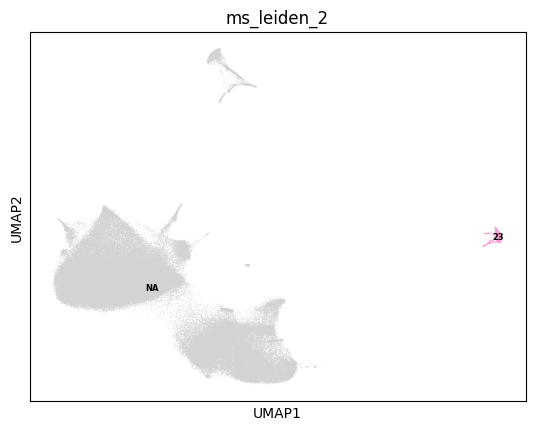

In [41]:
sc.pl.umap(adata, color = 'ms_leiden_2', groups = prdm1_pos_cl, 
           legend_loc='on data', legend_fontsize=6)

In [42]:
keep_cl = set(aim2_pos_cl) - set(zeb2_pos_cl)
keep_cl = keep_cl - set(prdm1_pos_cl)
keep_cl = list(keep_cl)
keep_cl.sort()
keep_cl

['1', '13', '16', '17', '26', '3', '6']

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


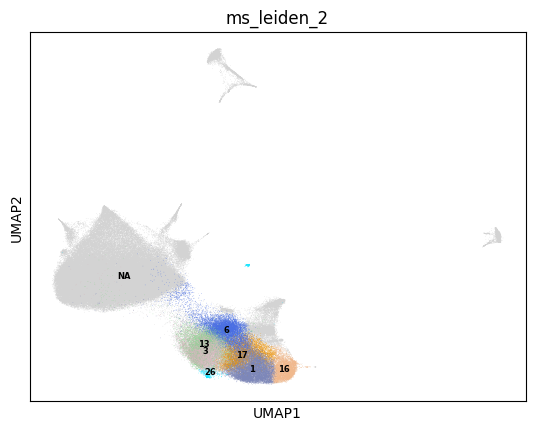

In [43]:
sc.pl.umap(adata, color = 'ms_leiden_2', groups = keep_cl, 
           legend_loc='on data', legend_fontsize=6)

In [44]:
allmem_MBCs = adata[adata.obs['ms_leiden_2'].isin(keep_cl)]

## Recluster memory cells

As for the broader B cell clustering, we trim Immunoglobulin genes, then perform harmony and clustering.

In [45]:
allmem_MBCs.raw = allmem_MBCs

In [46]:
sc.pp.normalize_total(allmem_MBCs, target_sum=1e4)
sc.pp.log1p(allmem_MBCs)

In [47]:
sc.pp.highly_variable_genes(allmem_MBCs)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [48]:
igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

In [49]:
allmem_MBCs = allmem_MBCs[:, allmem_MBCs.var_names[allmem_MBCs.var['highly_variable']]]
filtered_genes = [gene for gene in allmem_MBCs.var_names if gene not in exl_genes]
allmem_MBCs = allmem_MBCs[:, filtered_genes]

In [50]:
sc.pp.scale(allmem_MBCs)
sc.tl.pca(allmem_MBCs, svd_solver='arpack')
sce.pp.harmony_integrate(allmem_MBCs, 'cohort.cohortGuid',max_iter_harmony = 30)
sc.pp.neighbors(allmem_MBCs, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(allmem_MBCs,min_dist=0.05)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-02-26 21:12:35,104 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-26 21:12:57,099 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-26 21:12:57,413 - harmonypy - INFO - Iteration 1 of 30
2024-02-26 21:13:22,607 - harmonypy - INFO - Iteration 2 of 30
2024-02-26 21:13:47,537 - harmonypy - INFO - Iteration 3 of 30
2024-02-26 21:14:11,885 - harmonypy - INFO - Iteration 4 of 30
2024-02-26 21:14:21,095 - harmonypy - INFO - Converged after 4 iterations


In [51]:
sc.tl.leiden(allmem_MBCs, resolution = 2, key_added = "ms_leiden_2.5")

In [52]:
cell_class = 'b-cells-mem-no-ig'
mem_h5ad = 'output/ref_pbmc_{c}_subset_{d}.h5ad'.format(c = cell_class, d = date.today())
allmem_MBCs.write_h5ad(mem_h5ad)

## Save UMAP coordinates and labels

In [53]:
umap_mat = allmem_MBCs.obsm['X_umap']

In [54]:
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

In [55]:
obs = allmem_MBCs.obs
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [56]:
mem_csv = 'output/ref_{c}_clustered_umap_meta_{d}.csv'.format(c = cell_class, d = date.today())

In [57]:
obs.to_csv(mem_csv)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
/opt/conda/lib/python3.10/site-packages/pandas/core/

In [58]:
mem_parquet = 'output/ref_{c}_clustered_umap_meta_{d}.parquet'.format(c = cell_class, d = date.today())

In [59]:
obs = obs.to_parquet(mem_parquet)

## Plot markers for memory cell clusters

In [60]:
allmem_MBCs=allmem_MBCs.raw.to_adata()

In [61]:
allmem_MBCs.shape

(49408, 33538)

In [62]:
sc.pp.normalize_total(allmem_MBCs, target_sum=1e4)
sc.pp.log1p(allmem_MBCs)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


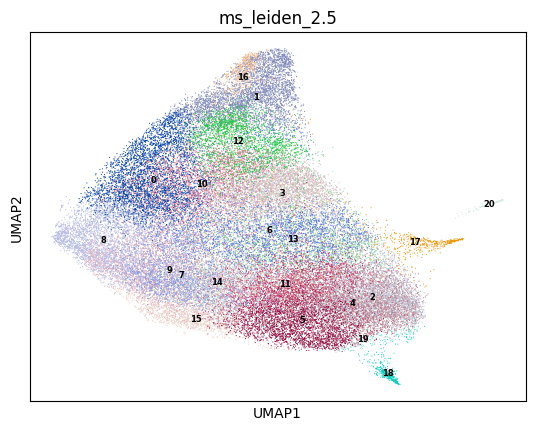

In [63]:
sc.pl.umap(allmem_MBCs, color = 'ms_leiden_2.5', legend_loc='on data', legend_fontsize=6)

In [64]:
mem_markers = {
    'markers_t2': ['IL4R', 'IGHE', 'FCER2', 'COCH', 'MEF2C'],
    'markers_cd95': ['FAS', 'ITGAX', 'AIM2', 'CD27'],
    'non_switch_b': ['IGHD', 'IGHM'],
    'early_mem': ['IGHD', 'IGHM', 'CD27', 'CD79B', 'FCGR2B', 'MEF2C', 'AIM2'],
    'ap1': ['JUN', 'MYC', 'CD69', 'FOS'],
}

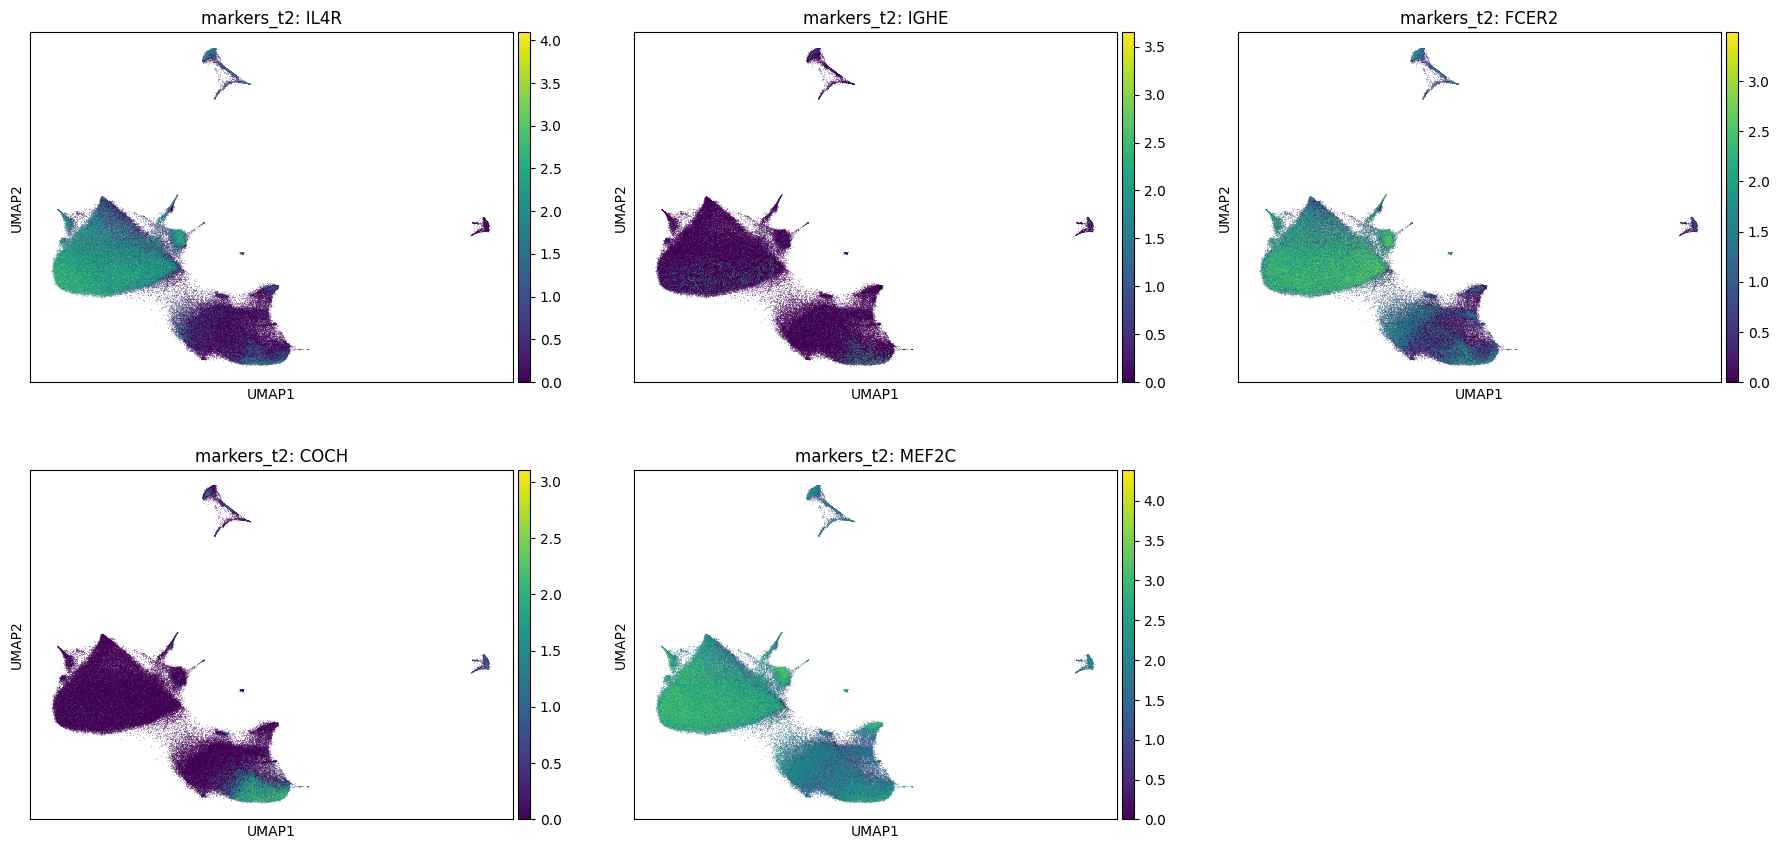

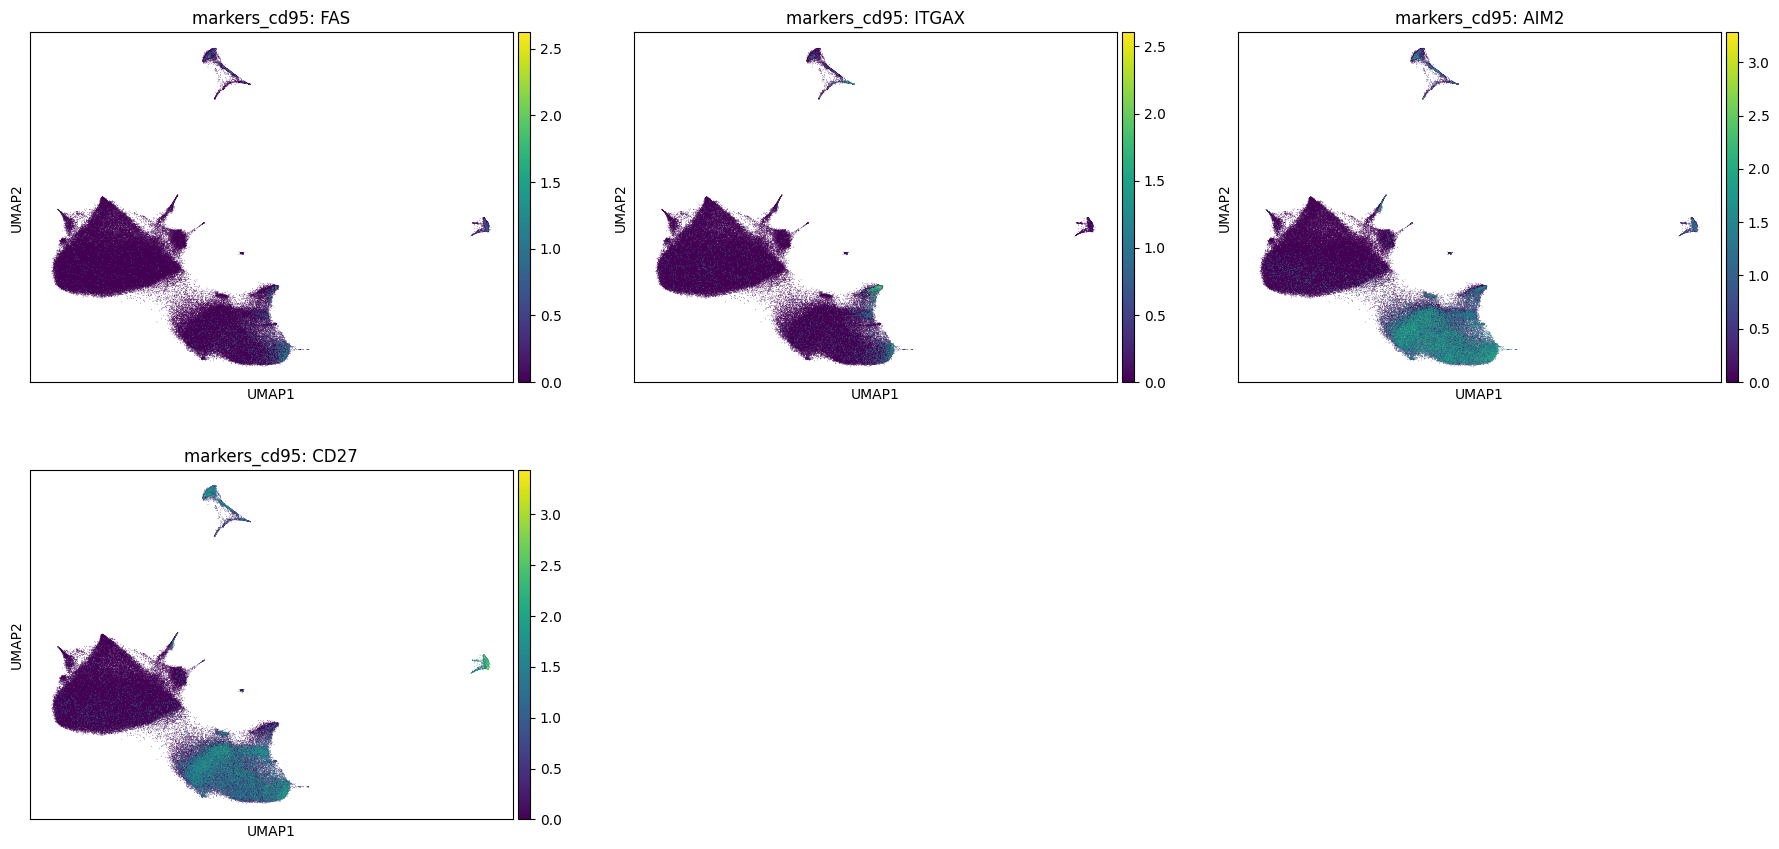

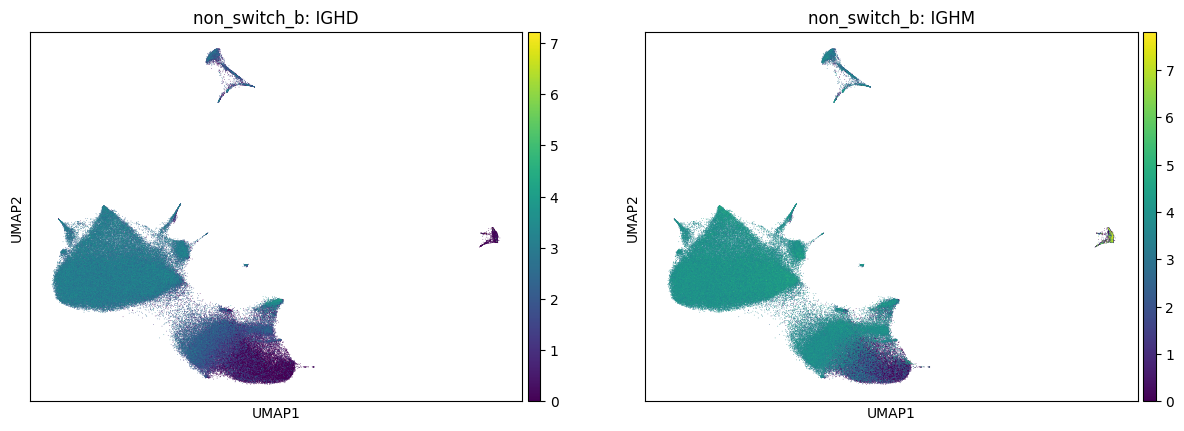

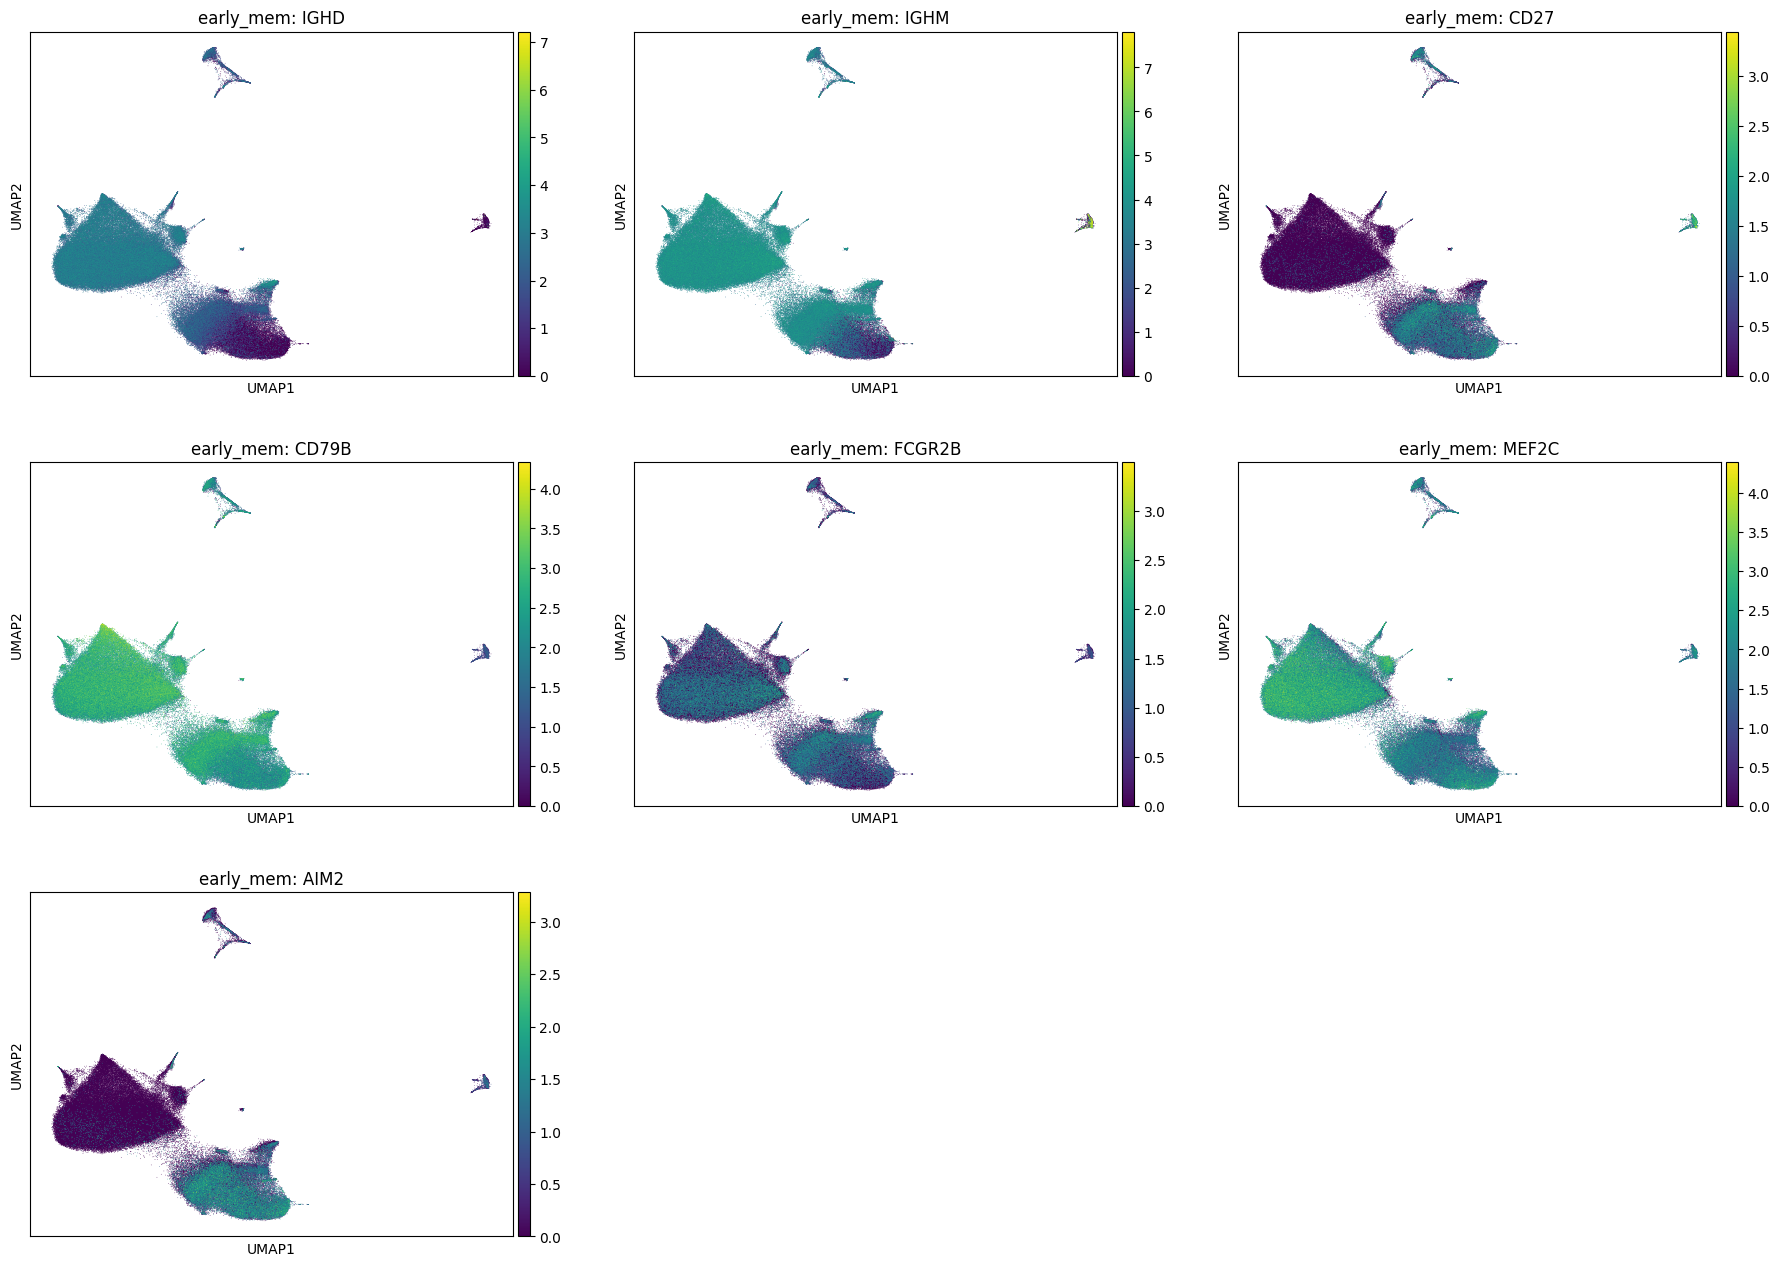

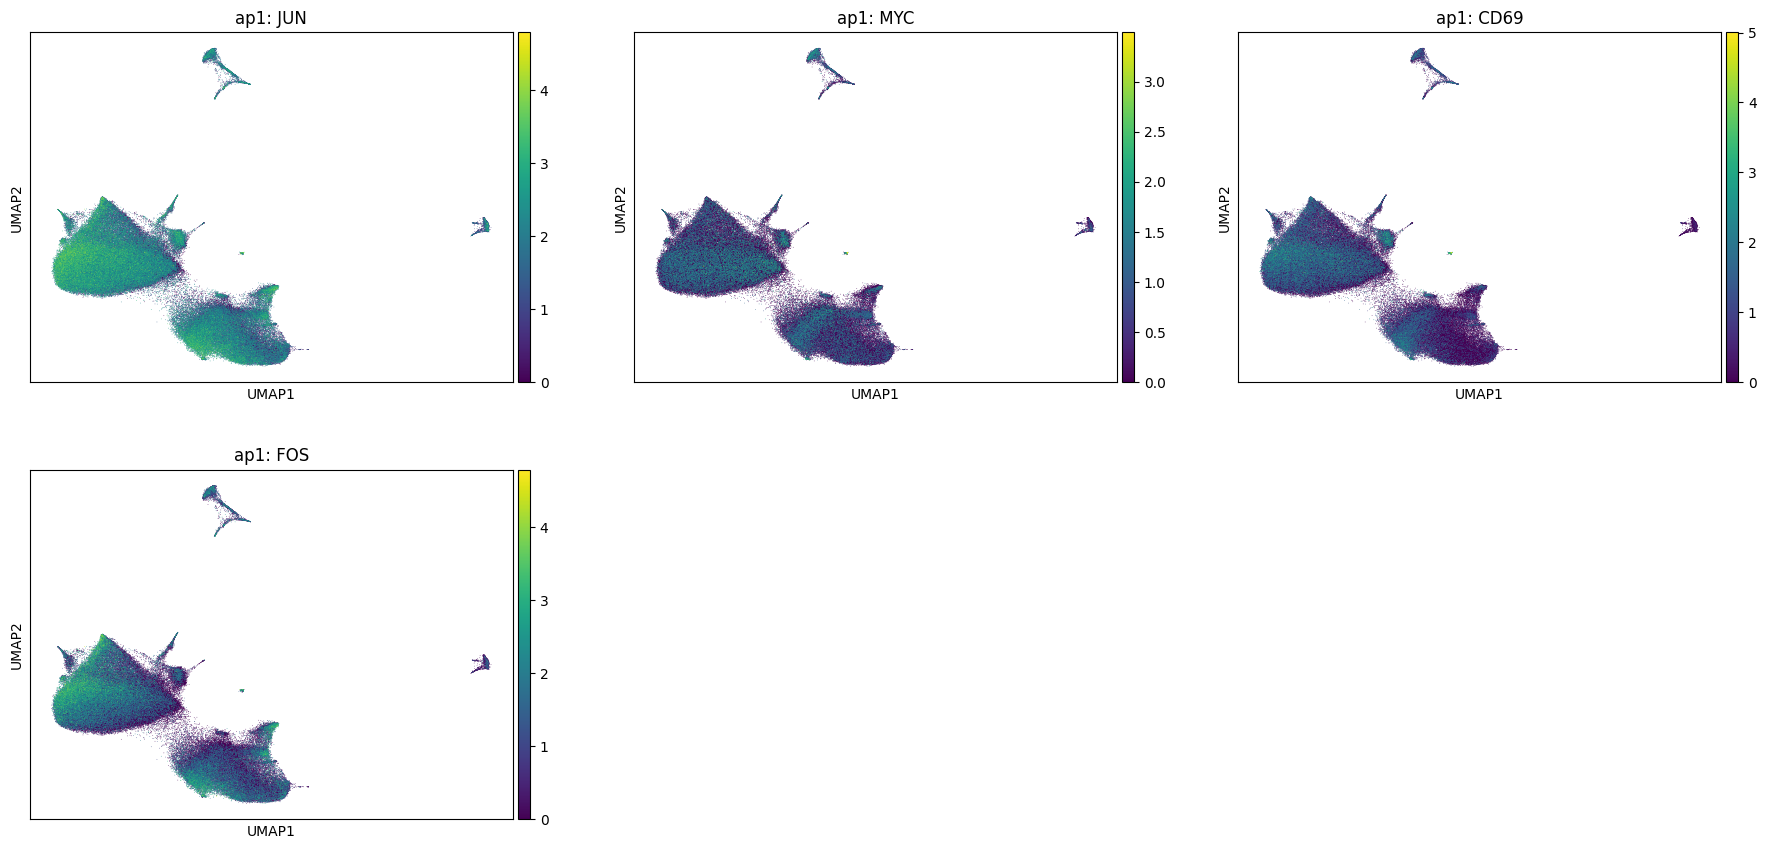

In [65]:
for panel,genes in mem_markers.items():
    titles = [panel + ': ' + g for g in genes]
    sc.pl.umap(
        adata, 
        color = genes, 
        size = 1, 
        ncols = 3, 
        frameon = True,
        title = titles
    )

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


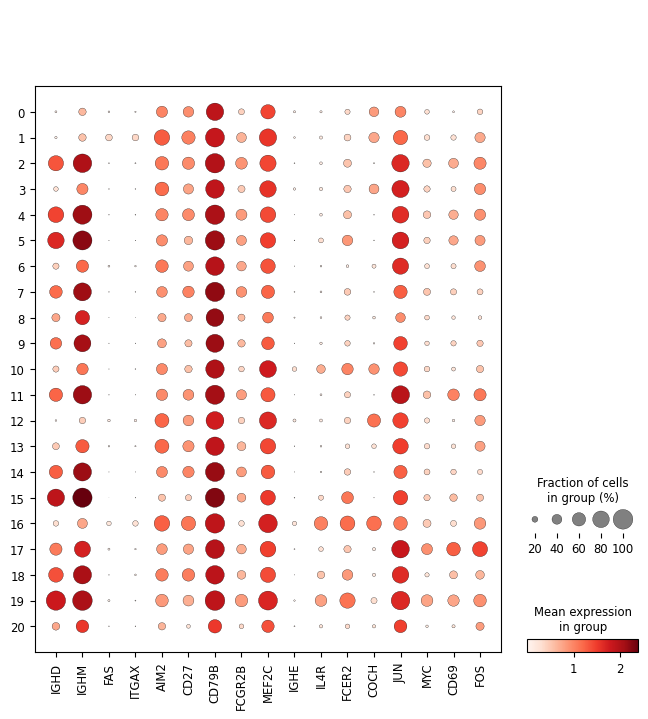

In [66]:
mem_marker_list = ['IGHD', 'IGHM', 'FAS', 
                   'ITGAX', 'AIM2', 'CD27', 
                   'CD79B', 'FCGR2B', 'MEF2C', 
                   'IGHE', 'IL4R', 'FCER2', 
                   'COCH', 'JUN', 'MYC', 
                   'CD69', 'FOS'] 
sc.pl.dotplot(allmem_MBCs, mem_marker_list, groupby = 'ms_leiden_2.5')

## Upload assembled data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [67]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'B cell no-Ig reclustering {d}'.format(d = date.today())

In [68]:
in_files = [h5ad_uuid]

In [69]:
in_files

['25032725-d25a-402e-9adf-f34353443507']

In [70]:
out_files = [no_ig_h5ad, no_ig_csv, no_ig_parquet,
             mem_h5ad, mem_csv, mem_parquet]

In [71]:
out_files

['output/ref_pbmc_b-cells-no-ig_subset_2024-02-26.h5ad',
 'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.csv',
 'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.parquet',
 'output/ref_pbmc_b-cells-mem-no-ig_subset_2024-02-26.h5ad',
 'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.csv',
 'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.parquet']

In [72]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

you are trying to upload file_ids... ['output/ref_pbmc_b-cells-no-ig_subset_2024-02-26.h5ad', 'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.csv', 'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.parquet', 'output/ref_pbmc_b-cells-mem-no-ig_subset_2024-02-26.h5ad', 'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.csv', 'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'd2d9323c-51f5-4951-a8ac-926c0dd927e2',
 'files': ['output/ref_pbmc_b-cells-no-ig_subset_2024-02-26.h5ad',
  'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.csv',
  'output/ref_b-cells-no-ig_clustered_umap_meta_2024-02-26.parquet',
  'output/ref_pbmc_b-cells-mem-no-ig_subset_2024-02-26.h5ad',
  'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.csv',
  'output/ref_b-cells-mem-no-ig_clustered_umap_meta_2024-02-26.parquet']}

In [73]:
import session_info
session_info.show()